# PPO Report

This notebook loads a pre-trained model and runs evaluation and visualization.
No training is required — just place the model `.zip` file in the expected path and run all cells.

---

## 1. Introduction

Deep Reinforcement Learning (DRL) has become a central paradigm for solving complex sequential decision‑making problems, particularly those involving continuous state spaces, stochastic dynamics, and delayed rewards. Among the wide range of DRL algorithms, Deep Q‑Network (DQN) and Proximal Policy Optimization (PPO) represent two fundamentally different approaches: value‑based learning and policy‑based learning. Comparing these two algorithms provides valuable insight into how different learning mechanisms behave under the same environment conditions.

In this project, we investigate the performance of DQN and PPO in the LunarLander‑v3 environment from Gymnasium. This environment simulates the control of a lunar lander that must descend and touch down smoothly within a designated landing zone. The agent receives an 8‑dimensional continuous state vector and must choose among four discrete actions, making the task suitable for both value‑based and policy‑based methods. The environment includes dense rewards, penalties for fuel consumption, and strong negative rewards for crashes, creating a challenging control problem that requires stability, precision, and efficient exploration.

The goal of this work is to train, evaluate, and compare DQN and PPO under controlled experimental conditions. We analyse their learning curves, sample efficiency, stability across multiple random seeds, and qualitative behaviour through recorded simulations. Additionally, we examine theoretical aspects such as overestimation bias in DQN, the role of clipping and Generalized Advantage Estimation (GAE) in PPO, and the differences between ε‑greedy and entropy‑driven exploration.

By combining quantitative metrics with qualitative observations, this study aims to provide a comprehensive understanding of how DQN and PPO behave in the LunarLander‑v3 environment, highlighting their strengths, limitations, and the impact of hyperparameter choices on the final performance.

## 2. Environment Analysis

---

### 2.1 State Space

The LunarLander‑v3 environment provides an 8‑dimensional continuous state vector describing the physical configuration of the lander at each timestep:
1. Horizontal position (x) relative to the landing zone  
2. Vertical position (y) above the ground  
3. Horizontal velocity (vx)  
4. Vertical velocity (vy)  
5. Lander angle ($\theta$)  
6. Angular velocity ($\omega$)  
7. Left leg contact indicator (0 or 1)  
8. Right leg contact indicator (0 or 1)

These variables allow the agent to infer its location, orientation, stability, and motion, which are essential for controlling the descent.

### 2.2 Action Space

The action space is discrete with four possible actions:

* 0 - Do nothing  
* 1 - Fire left thruster (pushes the lander to the right)  
* 2 - Fire main thruster (reduces vertical speed)  
* 3 - Fire right thruster (pushes the lander to the left)

These actions allow the agent to control both horizontal movement and vertical descent.

### 2.3 Reward Function

The reward function is dense and designed to encourage smooth and stable landings while penalizing unsafe or inefficient behaviour.

**Positive rewards include:**
- Moving closer to the landing zone  
- Reducing horizontal and vertical velocity  
- Maintaining a stable angle  
- Each leg touching the ground (+10 each)  
- Successful landing (+100 to +140)

**Penalties include:**
- High velocities  
- Large tilt angles  
- Excessive use of the main thruster (fuel cost)  
- Crashes (around −100)

A score of **200 or higher** typically indicates a successful landing.

### 2.4 Termination Rules

An episode terminates when one of the following occurs:
1. **Successful landing** within the designated zone  
2. **Crash** due to excessive speed or unstable angle  
3. **Leaving the screen boundaries**  
4. **Reaching the maximum number of steps** allowed by the environment

These termination conditions apply equally to both PPO and DQN agents.


## 3. Experimental Setup

---

This section describes the training and evaluation methodology used to compare DQN and PPO in the LunarLander‑v3 environment. All experiments were conducted under controlled and reproducible conditions to ensure a fair comparison between the two algorithms.

### 3.1 Total Environment Steps

Both DQN and PPO were trained using a total of **1,000,000 environment steps per seed**.  
Since the project requires at least three seeds, this results in:

- 3 seeds × 1,000,000 steps = **3,000,000 training steps per algorithm**

Using the same number of interactions ensures that the comparison between DQN and PPO is based on equal sample budgets.


### 3.2 Hyperparameter Configurations

The hyperparameters for each algorithm were selected based on Stable‑Baselines3 recommendations and refined through empirical testing.  
Tables 1 and 2 summarize the final configurations used for training.


| Hyperparameter          | Value            |
|-------------------------|------------------|
| Policy                  | MlpPolicy        |
| Learning rate           | 5e‑4             |
| Buffer size             | 100,000          |
| Batch size              | 128              |
| Gamma (discount factor) | 0.99             |
| Learning starts         | 1,000            |
| Exploration strategy    | $\epsilon$‑greedy         |
| Exploration fraction    | 0.12             |
| Final ε                 | 0.10             |
| Target update interval  | 250              |
| Device                  | CPU/GPU          |
| Network architecture    | 2 × 256 MLP      |

**Table 1** — DQN Hyperparameters


| Hyperparameter          | Value            |
|-------------------------|------------------|
| Policy                  | MlpPolicy        |
| Learning rate           | 2.5e‑4           |
| n_steps                 | 2048             |
| Batch size              | 64               |
| n_epochs                | 10               |
| Gamma (discount factor) | 0.999            |
| GAE λ                   | 0.95             |
| Clip range              | 0.20             |
| Entropy coefficient     | 0.01             |
| Device                  | CPU/GPU          |
| Network architecture    | 2 × 256 MLP      |

**Table 2** — PPO Hyperparameters

These hyperparameters were kept constant across all seeds to isolate the effect of stochasticity in training.

### 3.3 Random Seeds

To evaluate robustness and training stability, both algorithms were trained using **three different random seeds**:
- Seed 1: **42**  
- Seed 2: **123**
- Seed 3: **3407**

Each seed corresponds to a full independent training run of 1,000,000 steps.

### 3.4 Evaluation Protocol

In [1]:
import os, sys

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

import imageio
from IPython.display import Image

In [ ]:
# Configuration

SEED = 42

# "dqn" or "ppo"
SELECTED_ALGORITHM = "ppo"

NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
OUTPUT_DIR = os.path.join(NOTEBOOK_DIR, "outputs_" + SELECTED_ALGORITHM)
MODEL_LOAD_PATH = os.path.join(NOTEBOOK_DIR, "../../models", SELECTED_ALGORITHM, "model_" + SELECTED_ALGORITHM + "_1m")

GYMNASIUM_MODEL = "LunarLander-v3"

# Environment settings
WIND_ENABLED = False

EVALUATION_EPISODES = 100

# Algorithm class mapping
ALGORITHM_MAP = {"ppo": PPO, "dqn": DQN}
ALGORITHM_CLASS = ALGORITHM_MAP[SELECTED_ALGORITHM]

DEVICE = "cpu"

print(f"Algorithm: {SELECTED_ALGORITHM.upper()}")
print(f"Wind enabled: {WIND_ENABLED}")
print(f"Model path: {MODEL_LOAD_PATH}")

Algorithm: PPO
Wind enabled: False
Model path: c:\Users\catia\taap_p2\drafts\draft_03\../../models\ppo\model_ppo_1m


In [3]:
# Load the pre-trained model

def make_env_lunarlander():
    env = gym.make(GYMNASIUM_MODEL,
                   render_mode="rgb_array",
                   enable_wind=WIND_ENABLED)
    env.reset(seed=SEED)
    return env

env = DummyVecEnv([make_env_lunarlander])

MODEL = ALGORITHM_CLASS.load(
    MODEL_LOAD_PATH,
    env=env,
    device=DEVICE)

print(f"Loaded {SELECTED_ALGORITHM.upper()} model from: {MODEL_LOAD_PATH}")

Loaded PPO model from: c:\Users\catia\taap_p2\drafts\draft_03\../../models\ppo\model_ppo_1m


In [4]:
# Evaluation
evaluation_environment = Monitor(gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED))
evaluation_environment.reset(seed=SEED)

print(f"Starting Test: {EVALUATION_EPISODES} episodes...")

episode_rewards, _ = evaluate_policy(
    MODEL,
    evaluation_environment,
    n_eval_episodes=EVALUATION_EPISODES,
    deterministic=True,
    return_episode_rewards=True
)

# Show statistics
rewards = np.array(episode_rewards)
stats = {
    "Metric": ["Mean Reward", "Standard Deviation", "Minimum Reward", "Maximum Reward", "Success Rate (Score > 200)"],
    "Value": [
        f"{np.mean(rewards):.2f}",
        f"{np.std(rewards):.2f}",
        f"{np.min(rewards):.2f}",
        f"{np.max(rewards):.2f}",
        f"{(rewards >= 200).sum() / EVALUATION_EPISODES * 100:.1f}%"
    ]
}

df_stats = pd.DataFrame(stats)
print("\n*** MODEL EVALUATION SUMMARY ***")
print(df_stats.to_string(index=False))

evaluation_environment.close()

Starting Test: 100 episodes...

*** MODEL EVALUATION SUMMARY ***
                    Metric  Value
               Mean Reward 266.92
        Standard Deviation  35.19
            Minimum Reward  55.04
            Maximum Reward 310.09
Success Rate (Score > 200)  97.0%


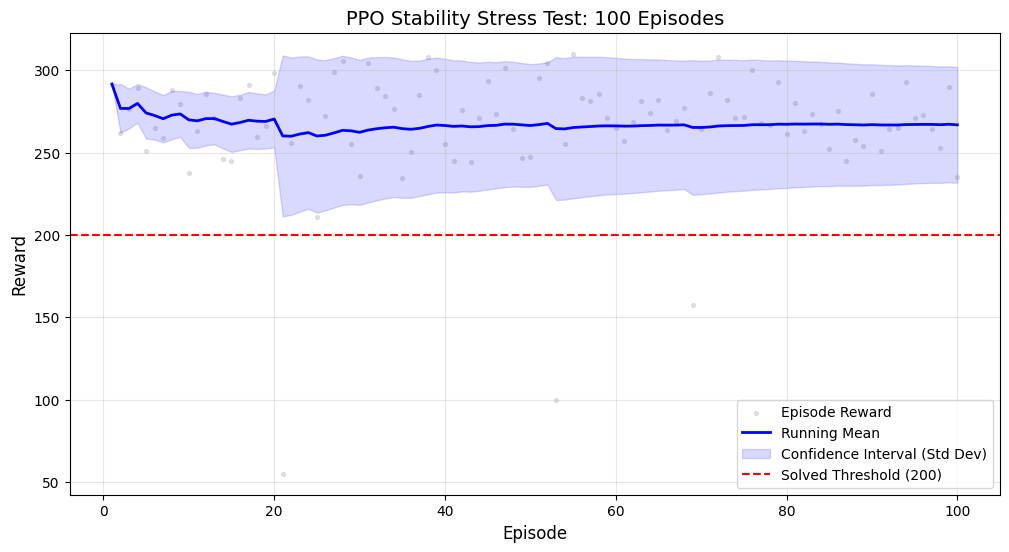

In [5]:
# Convergence Plot
episodes = np.arange(1, len(rewards) + 1)
running_mean = np.cumsum(rewards) / episodes
running_std = np.array([np.std(rewards[:i]) for i in episodes])

plt.figure(figsize=(12, 6))
plt.scatter(episodes, rewards, color='gray', alpha=0.2, s=8, label='Episode Reward')
plt.plot(episodes, running_mean, color='blue', linewidth=2, label='Running Mean')
plt.fill_between(episodes, running_mean - running_std, running_mean + running_std, color='blue', alpha=0.15, label='Confidence Interval (Std Dev)')
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')

plt.title(f"{SELECTED_ALGORITHM.upper()} Stability Stress Test: {EVALUATION_EPISODES} Episodes", fontsize=14)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

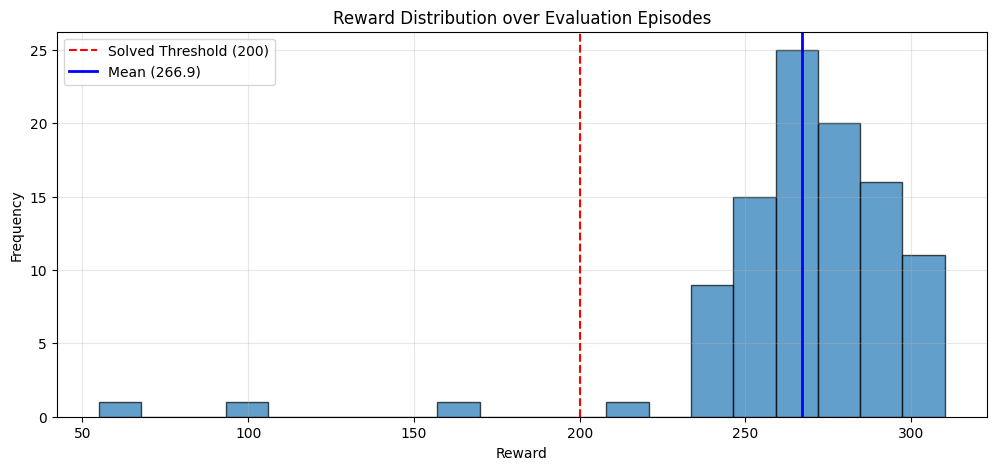

In [6]:
# Reward Distribution Histogram
plt.figure(figsize=(12, 5))
plt.hist(rewards, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.axvline(x=np.mean(rewards), color='blue', linestyle='-', linewidth=2, label=f'Mean ({np.mean(rewards):.1f})')
plt.title('Reward Distribution over Evaluation Episodes')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Saved visualization to: c:\Users\catia\taap_p2\drafts\draft_03\outputs_ppo\ppo_lunarlander.gif


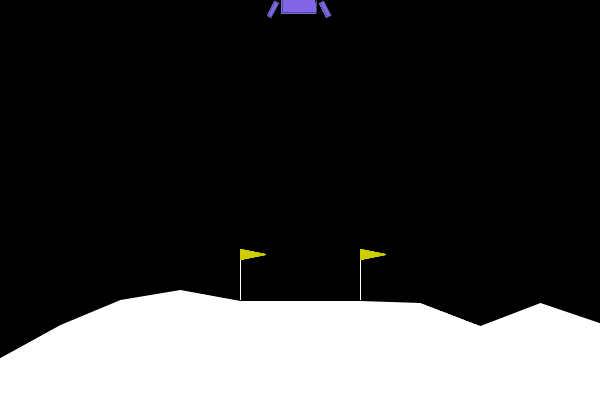

In [7]:
# GIF Visualization
visualization_environment = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)

frames = []
obs, info = visualization_environment.reset(seed=SEED)
done = False

while not done:
    action, _ = MODEL.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = visualization_environment.step(action)
    done = terminated or truncated
    frames.append(visualization_environment.render())

visualization_environment.close()

gif_path = os.path.join(OUTPUT_DIR, SELECTED_ALGORITHM + "_lunarlander.gif")
imageio.mimsave(gif_path, frames, fps=30)

print(f"Saved visualization to: {gif_path}")
Image(filename=gif_path)

---

## Additional plot cells can go here



---

# 7. Conceptual Discussion

This section presents a theoretical discussion of the core conceptual differences between value-based and policy-based reinforcement learning methods, the sources of instability in deep RL, and the exploration mechanisms used in DQN and PPO.

---

## 7.1 Value-Based vs Policy-Based Learning

Reinforcement Learning algorithms can be categorised according to what is parameterised and optimised.

### Value-Based Learning

Value-based methods approximate a value function, typically the action-value function:

$$
Q^\pi(s,a) = \mathbb{E}_\pi \left[ \sum_{t=0}^{\infty} \gamma^t r_t \mid s_0 = s, a_0 = a \right]
$$

The optimal policy is derived implicitly:

$$
\pi(s) = \arg\max_a Q(s,a)
$$

Deep Q-Networks (DQN) approximate:

$$
Q(s,a; \theta)
$$

and update parameters using the Bellman optimality equation:

$$
Q(s,a) = r + \gamma \max_{a'} Q(s',a')
$$

This introduces **bootstrapping**, since the target depends on the model’s own predictions.

Key characteristics:

- Off-policy learning  
- Bootstrapping  
- Policy extracted via maximisation  

However, the use of the max operator combined with function approximation introduces instability.

### Policy-Based Learning

Policy-based methods parameterise the policy directly:

$$
\pi_\theta(a|s)
$$

and optimise the expected return:

$$
J(\theta) = \mathbb{E}_{\pi_\theta}[R]
$$

Using the policy gradient theorem:

$$
\nabla_\theta J(\theta) =
\mathbb{E}_{\pi_\theta}
\left[
\nabla_\theta \log \pi_\theta(a|s) A^\pi(s,a)
\right]
$$

These methods:

- Learn the policy directly  
- Avoid explicit maximisation over value estimates  
- Naturally handle continuous action spaces  

Because they do not rely on a max operator over Q-values, they tend to be structurally more stable in deep settings.


## 7.2 Overestimation and Instability in Value-Based Algorithms

### Overestimation Bias

Overestimation arises from the maximisation step:

$$
\max_a Q(s,a)
$$

If Q-value estimates contain zero-mean noise:

$$
\mathbb{E}[\max(X_i)] \ge \max(\mathbb{E}[X_i])
$$

Thus, even unbiased estimators lead to positively biased maximum estimates.

In DQN, the same network:

1. Selects the action (argmax)  
2. Evaluates the action  

This coupling amplifies overestimation bias.


### Structural Instability: The Deadly Triad

Deep value-based RL combines:

1. Function approximation  
2. Bootstrapping  
3. Off-policy learning  

This combination is known as the **deadly triad**, which may cause divergence or unstable oscillations.

PPO avoids these structural issues because:

- It does not use a max over Q-values  
- It performs on-policy updates  
- Value estimates are auxiliary rather than directly driving action selection  


## 7.3 PPO Clipping and Generalised Advantage Estimation (GAE)

### PPO Clipped Objective

PPO constrains policy updates through the clipped surrogate objective:

$$
L^{CLIP}(\theta) =
\mathbb{E}
\left[
\min
\left(
r_t(\theta) A_t,
\text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) A_t
\right)
\right]
$$

where:

$$
r_t(\theta) =
\frac{\pi_\theta(a_t|s_t)}
{\pi_{\theta_{old}}(a_t|s_t)}
$$

This objective:

- Approximates a trust-region method  
- Prevents excessively large updates  
- Improves training stability  


### Generalised Advantage Estimation (GAE)

The advantage function is defined as:

$$
A^\pi(s,a) = Q^\pi(s,a) - V^\pi(s)
$$

GAE computes:

$$
A_t^{GAE(\lambda)} =
\sum_{l=0}^{\infty}
(\gamma \lambda)^l \delta_{t+l}
$$

where the temporal-difference residual is:

$$
\delta_t =
r_t + \gamma V(s_{t+1}) - V(s_t)
$$

The parameter \( \lambda \in [0,1] \) controls the bias-variance trade-off:

- \( \lambda = 0 \): lower variance, higher bias  
- \( \lambda = 1 \): lower bias, higher variance  

GAE reduces variance in policy gradient updates while maintaining acceptable bias, improving sample efficiency and stability.


## 7.4 ε-Greedy vs Entropy-Driven Exploration

### ε-Greedy Exploration (DQN)

The behaviour policy is defined as:

$$
\pi(a|s) =
\begin{cases}
\text{random action} & \text{with probability } \epsilon \\
\arg\max_a Q(s,a) & \text{otherwise}
\end{cases}
$$

Limitations:

- Uniform and uninformed exploration  
- Independent of uncertainty  
- Becomes fully greedy as \( \epsilon \to 0 \)  

Exploration is externally imposed rather than integrated into optimisation.


### Entropy-Regularised Exploration (PPO)

PPO includes an entropy bonus in the objective:

$$
L =
L^{CLIP}
+
\beta
\mathbb{E}[H(\pi_\theta(\cdot|s))]
$$

where entropy is defined as:

$$
H(\pi) =
-
\sum_a
\pi(a|s)
\log \pi(a|s)
$$

This mechanism:

- Encourages stochastic policies early in training  
- Gradually reduces randomness  
- Couples exploration with optimisation  

Unlike ε-greedy, exploration is intrinsic to the learning objective.


## Conceptual Summary

In summary, value-based methods optimise an approximation of the value function and derive the policy implicitly through action maximisation. This structural reliance on the max operator and bootstrapping introduces overestimation bias and makes deep value-based methods particularly sensitive to instability when combined with function approximation and off-policy learning. In contrast, policy-based methods directly parameterise and optimise the policy, avoiding explicit maximisation over value estimates and thereby reducing structural sources of instability. PPO further improves stability through its clipped surrogate objective, which constrains policy updates, and through Generalised Advantage Estimation, which manages the bias-variance trade-off in gradient estimates. Regarding exploration, ε-greedy strategies impose external and uninformed randomness that vanishes as ε decays, whereas entropy-regularised exploration integrates stochasticity directly into the optimisation objective, allowing exploration to adapt naturally as learning progresses. Overall, these theoretical differences explain why PPO typically exhibits smoother and more stable learning dynamics compared to DQN in complex environments.

# 7. Conceptual Discussion (Theory–Empirical Connection)

This section provides a critical theoretical discussion of the core conceptual differences between value-based and policy-based reinforcement learning, explicitly grounded in the empirical findings observed in the LunarLander-v3 experiments. Rather than presenting theory in isolation, the discussion links each conceptual aspect to the training dynamics, stability patterns, and performance variability observed for DQN and PPO in this project.

---

## 7.1 Value-Based vs Policy-Based Learning: Practical Implications

### Value-Based Learning (DQN)

Value-based methods aim to approximate the optimal action-value function:

\[
Q^\pi(s,a) = \mathbb{E}_\pi \left[ \sum_{t=0}^{\infty} \gamma^t r_t \mid s_0 = s, a_0 = a \right]
\]

and derive the policy implicitly:

\[
\pi(s) = \arg\max_a Q(s,a).
\]

In DQN, a neural network approximates \( Q(s,a;\theta) \), and learning proceeds via bootstrapped Bellman updates:

\[
Q(s,a) \leftarrow r + \gamma \max_{a'} Q(s',a').
\]

**Connection to empirical results.**  
In the experiments, DQN was able to achieve high final performance, occasionally matching or exceeding PPO in peak reward. However, training trajectories were highly non-monotonic, with pronounced oscillations and, in some seeds, late-stage performance collapse. This behaviour directly reflects the structural properties of value-based learning: policy quality is entirely mediated through the accuracy and stability of Q-value estimates. When value estimation becomes unstable, the induced policy degrades, even after the task has already been “solved”.

This explains why strong DQN checkpoints appeared transiently and why model selection and early stopping were critical to recover high-performing policies.

### Policy-Based Learning (PPO)

Policy-based methods parameterise the policy directly:

\[
\pi_\theta(a|s),
\]

and optimise expected return:

\[
J(\theta) = \mathbb{E}_{\pi_\theta}[R].
\]

Using policy gradients:

\[
\nabla_\theta J(\theta) =
\mathbb{E}_{\pi_\theta}
\left[
\nabla_\theta \log \pi_\theta(a|s) A^\pi(s,a)
\right].
\]

**Connection to empirical results.**  
In contrast to DQN, PPO displayed smoother, more monotonic learning curves and far greater robustness across seeds. Because PPO updates the policy directly, performance is not mediated through a potentially unstable max operator over noisy value estimates. This structural difference explains why PPO training did not exhibit catastrophic collapses and why its learning curves were more predictable and reproducible across random initialisations.

---

## 7.2 Overestimation and Instability in Value-Based Algorithms

### Overestimation Bias

The maximisation operator introduces positive bias:

\[
\mathbb{E}[\max_i X_i] \ge \max_i \mathbb{E}[X_i],
\]

even when \( X_i \) are unbiased estimators. In DQN, the same network selects and evaluates actions, amplifying this bias.

**Empirical manifestation.**  
In the experiments, rising Q-values and unstable value loss dynamics were observed in some DQN runs, particularly in seeds that later exhibited performance collapse. These effects are consistent with overestimation bias, where inflated Q-values lead the agent to overcommit to suboptimal actions, destabilising learning.

### The Deadly Triad

DQN combines:

1. Function approximation  
2. Bootstrapping  
3. Off-policy learning  

This “deadly triad” is known to cause divergence and instability in deep RL.

**Empirical manifestation.**  
The late-stage collapse observed in one of the DQN seeds is a textbook example of this phenomenon: despite earlier competent performance, training continued to modify value estimates in a destabilising direction. This highlights that convergence in performance does not guarantee convergence in learning dynamics for value-based methods.

---

## 7.3 PPO Clipping and GAE as Stability Mechanisms

### PPO Clipped Objective

PPO constrains policy updates via:

\[
L^{CLIP}(\theta) =
\mathbb{E}
\left[
\min \left(
r_t(\theta) A_t,
\text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) A_t
\right)
\right].
\]

This prevents large, destructive policy updates.

**Empirical manifestation.**  
The absence of catastrophic drops in PPO performance and the bounded KL divergence and clipping fraction observed during training confirm the practical effectiveness of this theoretical mechanism. PPO’s clipped updates act as a soft trust region, preventing policy collapse even when gradients are noisy.

### Generalised Advantage Estimation (GAE)

GAE:

\[
A_t^{GAE(\lambda)} =
\sum_{l=0}^{\infty}
(\gamma \lambda)^l \delta_{t+l},
\]

reduces variance while controlling bias.

**Empirical manifestation.**  
The smooth improvement of PPO’s learning curves and stable value loss trajectories suggest that GAE contributed to lower-variance gradient estimates, improving sample efficiency and stabilising optimisation. This aligns with the observed faster and more reliable convergence of PPO relative to DQN.

---

## 7.4 ε-Greedy vs Entropy-Driven Exploration

### ε-Greedy (DQN)

Exploration is externally imposed:

\[
\pi(a|s) =
\begin{cases}
\text{random} & \text{with prob. } \epsilon, \\
\arg\max_a Q(s,a) & \text{otherwise}.
\end{cases}
\]

**Empirical implications.**  
Once ε decays, exploration becomes minimal, making DQN prone to premature exploitation and limited recovery from suboptimal behaviours. This rigid exploration schedule may partly explain why some DQN runs failed to recover after performance degradation.

### Entropy-Regularised Exploration (PPO)

Entropy is incorporated into the objective:

\[
L = L^{CLIP} + \beta \mathbb{E}[H(\pi_\theta)].
\]

**Empirical implications.**  
PPO maintained stochasticity in action selection longer into training, which likely contributed to its ability to avoid brittle policies and to recover from suboptimal trajectories. This intrinsic exploration mechanism aligns with the observed robustness and consistency of PPO across seeds.

---

## Critical Synthesis

The empirical results of this project strongly support the theoretical expectations regarding stability in deep reinforcement learning. While DQN can achieve high performance, its reliance on bootstrapped value estimation, maximisation over noisy predictions, and off-policy updates makes it structurally fragile in deep settings. PPO, by directly optimising the policy and constraining updates via clipping and GAE, demonstrates superior robustness and reproducibility.

Crucially, this study highlights that **final performance alone is an insufficient metric** for evaluating DRL algorithms. Training stability, sensitivity to random seeds, and resilience to optimisation noise are equally important. From both a theoretical and practical perspective, the results reinforce the view that policy-gradient methods such as PPO offer a more reliable foundation for deep reinforcement learning in complex, continuous-state environments.